In bootstrap methods, you sample from a set of data with replacement.  For example, given data $x_1 \dots x_n$, for $b = 1 \dots B$ let $X_B$ represent a sample of size n taken with replacement.  Consider the mean and variance of these B samples.  representing the bootstrap estimate of the mean at $\bar \theta_B$, we have $E( \bar \theta_B )=\theta$.  As far as variance, let the correlation coefficient between two estimates be $\rho = \text{corr} (\hat \theta_i, \hat \theta_j)$, with $\text{var} (\theta_i)=\sigma.$  Then $$
\text{var} \left( \bar \theta_B \right) = \frac{1-\rho}{B} \sigma^2 +\rho\sigma
$$
The observation about the mean follows from the observation that 
$
E( \bar \theta_B )= \frac{1}{B} B E(\hat  \theta)=\theta.
$
For the variance, let $S_B$ be the sum of of the $\hat \theta_i$, and observe that 
$$
\text{var} \left( \bar \theta_B \right) =E \left( (S_B/B-\mu)^2\right) =\frac{1}{B^2}E( S_B^2-2\mu B S_B+B^2 \mu^2)=\frac{1}{B^2}E( S_B^2-B^2\mu^2)=\frac{1}{B^2}E( S_B^2)-\mu^2.$$
Then, multiply out $S_B^2$ to obtain $$
E( S_B^2)= B E(\hat \theta_i^2)+B(B-1)E(\hat \theta_i \hat \theta_j), 
$$
so that 
$$
\text{var} \left( \bar \theta_B \right)= \frac{1}{B}E (\hat \theta_i^2)-\frac{1}{B}E(\hat \theta_i \hat \theta_j)+E(\hat \theta_i \hat \theta_j)=\frac{1}{B}(\sigma^2+\mu^2) + \left( 1-\frac{1}{B}\right) (\rho \sigma^2+\mu^2),
$$
the last line using the equalities $(E(\hat \theta_i \hat \theta_j)-\mu^2)/\sigma^2=\rho$ and $\sigma^2=E(\hat \theta_i^2)+\mu^2$
For linear statistics, $\rho$ is about 0.5, but there can be an advantage for nonlinear models for which the results are less correlated.  Thus for things like decision trees, we gain a reduction in variance.


sample mean of X =  -0.0492426728176
bootstrap mean of X =  -0.041272246828


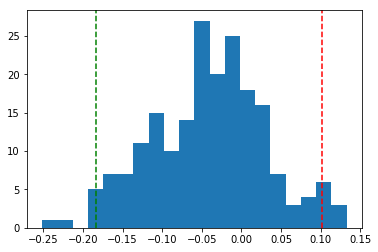

In [6]:
#simple bootstrap example.
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

B=200
N=20
X=np.random.randn(N)
print('sample mean of X = ', X.mean())
indiv_est=np.empty(B)
for b in range(B):
    sample = np.random.choice(X,size=B) #default is to sample with replacement
    indiv_est[b]=sample.mean()
    
bmean=indiv_est.mean()
bstd=indiv_est.std()
lower,upper =bmean+norm.ppf(0.025)*bstd, bmean+norm.ppf(0.975)*bstd
print('bootstrap mean of X = ',bmean )
plt.hist(indiv_est,bins=20)
plt.axvline(x=lower,linestyle='--',color='g',label='lower bound for 95% bootstrap')
plt.axvline(x=upper,linestyle='--',color='r',label='upper bound for 95% bootstrap')
plt.show()

    Bagging (bootstrap aggregation) is the application or bootstrap methods to regression or classification models.  To use a decision tree from the sci-kit learn package, you simply train $B$ versions of the decision tree (trained on $B$ different subsets of the data) and average the result.  Below we create some one dimensional data.

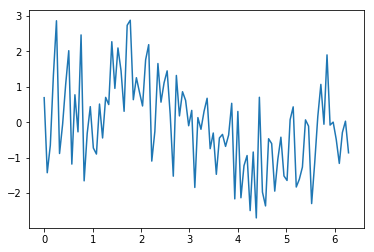

In [34]:
#some data
import numpy as np
import matplotlib.pyplot as plt
T = 100
x_axis = np.linspace(0, 2*np.pi, T)
y_axis = np.sin(x_axis)+np.random.randn(T)
N = 30
idx = np.random.choice(T, size=N, replace=False)
Xtrain = x_axis[idx].reshape(N, 1)
Ytrain = y_axis[idx]
idx2 = np.random.choice(T, size=N, replace=False)
Xtest = x_axis[idx2].reshape(N, 1)
Ytest = y_axis[idx2]

plt.plot(x_axis, y_axis)
plt.show()


Next, import sci-kit to use the DecisionTreeRegressor as our tree, and write a bagged regresor class

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle

class BaggedTree: 
    def __init__(self,B): #takes only one parameter, the number of trees.
        self.B=B
        
    def fit(self, X,Y):
        N=len(Y)
        self.models=[]
        for b in range(self.B):
            #sample with replacement
            idx=np.random.choice(N,size=N,replace=True)
            Xb=X[idx]
            Yb=Y[idx]
            
            #fit a decision tree to the chosen data
            model=DecisionTreeRegressor()
            model.fit(Xb,Yb)
            self.models.append(model)
    def predict(self,X):
        N=len(X)
        predictions=np.zeros(N) #create an appropriate length of zeros to add things to
        for model in self.models:
            predictions+=model.predict(X) #add each prediction 
        return(predictions /self.B) #return the average prediction
    
    def score(self, X, Y):
        d1 = Y - self.predict(X)
        d2 = Y - Y.mean()
        return( 1 - d1.dot(d1) / d2.dot(d2)) #r^2 = 1 -SS_residuals/SS_total
        


Now test out on our training and test sets:

In [41]:
model=BaggedTree(1)
model.fit(Xtrain,Ytrain)
model.score(Xtest,Ytest)

0.24780622624768645

In [42]:
model=BaggedTree(100)
model.fit(Xtrain,Ytrain)
model.score(Xtest,Ytest)

0.51720288488185162

For classification, the process is the same, adding posterior probabilities or 1/0.  Bagging (above) tends to work well for low bias, high variance models such as (deep enough) decision trees.  However, the variance reduction from bootstrapping is limited by correlation between models.  Random forest is a modification of bagging which builds large numbers of de-correlated trees, then averaging them.  They require few parameter choices, and so little tuning.  The algorithm is as follows:
For $b=1\dots B$:
    Draw a bootstrap sample $Z^*$ of size N from the training data
    Grow a tree T_b from the data by recursively repeating the following steps for each terminal node until max depth is reached:
    1. Select m variables from the p possible variables
    2. Pick the bets variable split-point among the m
    3. split the node into 2 daughter nodes
    
Output the ensemble $T_1 \dots T_B$.  For prediction of a new point $x$:
Regression:  $\hat f (x) = \frac{1}{B} \sum_{b=1}^B T_b(x)$
Classification:  Majority vote among trees

In order to generate the data, we use the sci-kit learn make_regression and make_classification functions to generate data for examples.  Each one will have 100 features, of which 10 will be informative (part of the model) and the rest are noise.

In [62]:
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
X, Y =make_regression(n_samples=1000, n_features=100, n_informative=10)
x_train, x_test,y_train,  y_test = train_test_split(X,Y,test_size=.30)


In [76]:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_estimators=10,max_depth=10)
model.fit(x_train,y_train)
print(model.score(x_test,y_test))

model=RandomForestRegressor(n_estimators=1000,max_depth=10)
model.fit(x_train,y_train)
print(model.score(x_test,y_test))

0.664042452705
0.729338971844


By way of comparison with bagging...

In [67]:
from sklearn.ensemble import BaggingRegressor

model=BaggingRegressor(n_estimators=10)
model.fit(x_train,y_train)
print(model.score(x_test,y_test))

model=BaggingRegressor(n_estimators=1000)
model.fit(x_train,y_train)
print(model.score(x_test,y_test))

0.71083665918
0.729917622028


Note that above we used the default bagging regressor model, but you can specify which model to use...

In [72]:
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()

In [73]:
model=BaggingRegressor(base_estimator=dt,n_estimators=10)
model.fit(x_train,y_train)
print(model.score(x_test,y_test))

0.684322219165


The variable importance is a measure of the contribution of each input variable in predicting the response.  For a single decision tree, T, Breiman proposed that for each predictor variable $X_\ell$, the measure should be
$$
I_\ell^2(T) \sum_{t=1}^{J-1} \hat i_t^2 1_{v(t)=\ell}(T).
$$
Above, T is the tree, t is the tree node, and $X_{v(t)}$ is the variable used to partition region assocated with node t.  The variable is chosen because it provides the argest improvement in squared error ($i_t^2$) over using a constant fit for the region.  For more than one tree, average the importance of each variable over the trees.


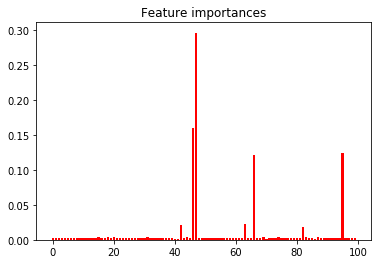

In [83]:
import matplotlib.pyplot as plt

importances = model.feature_importances_


plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances,
       color="r",  align="center")
plt.show()